In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload
%autoreload 2
from analysis_toolbox import *
from qualityBaseline import * 

In [3]:
from munkres import Munkres, print_matrix
def MunkresEuclidean(bb1,bb2):
    '''
    Given two worker's responses, 
    Compares Euclidean distances of all points in the polygon, 
    then find the best matching (min dist) config via Kuhn-Munkres
    '''
    matrix = spatial.distance.cdist(bb1,bb2,'euclidean')
    # print "Mat: " 
    # print np.ma.masked_equal(matrix,0)
    # print np.shape(np.ma.masked_equal(matrix,0))
    m = Munkres()
    try:
        indexes = m.compute(np.ma.masked_equal(matrix,0))
        total = 0
        for row, column in indexes:
            value = matrix[row][column]
            total += value
    #         print '(%d, %d) -> %d' % (row, column, value)
        return total         
    except(ValueError):
        print "bad"
        return 0

In [6]:
bb_info = pd.read_csv('computed_my_COCO_BBvals.csv')
bbg_info = pd.read_csv('my_ground_truth.csv')

In [20]:
from shapely.geometry import box,Polygon

In [ ]:
Polygon(zip(obj_x_locs[0],obj_y_locs[0])).buffer(0)

In [178]:
oid = 8
worker =  bb_info[bb_info["object_id"]==oid].ix[73]
bbg = bbg_info[bb_info["object_id"]==oid].ix[0]
obj_x_locs = [ast.literal_eval(worker["x_locs"]),ast.literal_eval(bbg["x_locs"])]
obj_y_locs = [ast.literal_eval(worker["y_locs"]),ast.literal_eval(bbg["y_locs"])]
polygon1 = Polygon(zip(obj_x_locs[0],obj_y_locs[0])).buffer(0)
polygon2 = Polygon(zip(obj_x_locs[1],obj_y_locs[1])).buffer(0)

In [70]:
from scipy.spatial.distance import cdist,pdist

In [89]:
worker_bb = np.array([ast.literal_eval(worker["x_locs"]),ast.literal_eval(worker["y_locs"])])
bbg = [ast.literal_eval(bbg["x_locs"]),ast.literal_eval(bbg["y_locs"])]

TypeError: list indices must be integers, not str

In [93]:
worker_bb = zip(ast.literal_eval(worker["x_locs"]),ast.literal_eval(worker["y_locs"]))

In [103]:
from scipy import interpolate

In [ ]:
griddata(worker_bb)

In [105]:
phi = np.linspace(0, 2.*np.pi, 40)
r = 0.5 + np.cos(phi)         # polar coords
x, y = r * np.cos(phi), r * np.sin(phi)    # 

In [108]:
x

array([  1.50000000e+00,   1.46779335e+00,   1.37398960e+00,
         1.22676039e+00,   1.03883011e+00,   8.26229207e-01,
         6.06729930e-01,   3.98123593e-01,   2.16513689e-01,
         7.47974314e-02,  -1.85116241e-02,  -6.00025687e-02,
        -5.15578176e-02,  -1.11022302e-16,   8.37644653e-02,
         1.86012966e-01,   2.91751238e-01,   3.86372455e-01,
         4.57257104e-01,   4.95146477e-01,   4.95146477e-01,
         4.57257104e-01,   3.86372455e-01,   2.91751238e-01,
         1.86012966e-01,   8.37644653e-02,   2.22044605e-16,
        -5.15578176e-02,  -6.00025687e-02,  -1.85116241e-02,
         7.47974314e-02,   2.16513689e-01,   3.98123593e-01,
         6.06729930e-01,   8.26229207e-01,   1.03883011e+00,
         1.22676039e+00,   1.37398960e+00,   1.46779335e+00,
         1.50000000e+00])

In [121]:
from scipy.interpolate import splprep,splev
x= ast.literal_eval(worker["x_locs"])
y= ast.literal_eval(worker["y_locs"])
tck, u =splprep([x,y],s=0,per=1)
u_new = np.linspace(u.min(),u.max(),3000)
new_points = splev(u_new, tck,der=0)

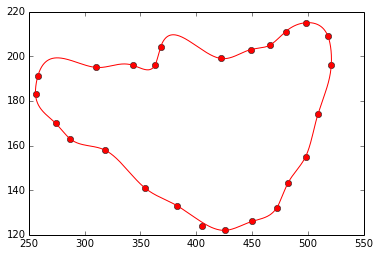

In [122]:
fig, ax = plt.subplots()
ax.plot(x, y, 'ro')
ax.plot(new_points[0], new_points[1], 'r-')
plt.show()

In [127]:
print obj_x_locs[0]

[[383, 354, 318, 287, 274, 256, 258, 310, 343, 363, 368, 422, 449, 466, 480, 498, 518, 521, 509, 498, 482, 472, 450, 426, 405], [302, 264, 254, 250, 250, 250, 248, 247, 247, 253, 267, 275, 290, 312, 337, 353, 363, 411, 435, 449, 462, 470, 478, 480, 494, 503, 511, 529, 532, 529, 522, 521, 516, 514, 506, 495, 493, 485, 483, 468, 453, 428, 371, 358, 334]]


In [128]:
from scipy.interpolate import splprep,splev

def parametric_interpolate(obj_x_locs,obj_y_locs,numPts,PLOT=False):
    '''
    Parametric interpolation of points between polygon boundaries
    Given obj_x_locs,obj_y_locs
    return a new set of interpolated obj_x_locs,obj_y_locs interpolated on numPts 
    '''
    interpolated_obj_x_locs = []
    interpolated_obj_y_locs = []
    for i in range(len(obj_x_locs)):
        x = obj_x_locs[i]
        y = obj_y_locs[i]
        tck, u =splprep([x,y],s=0,per=1)
        u_new = np.linspace(u.min(),u.max(),numPts)
        new_points = splev(u_new, tck,der=0)
        if PLOT: 
            plt.figure()
            plt.plot(x, y, 'ro')
            plt.plot(new_points[0], new_points[1], 'r-')
        interpolated_obj_x_locs.append(new_points[0])
        interpolated_obj_y_locs.append(new_points[1])
    return interpolated_obj_x_locs,interpolated_obj_y_locs


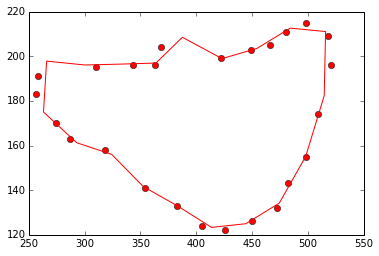

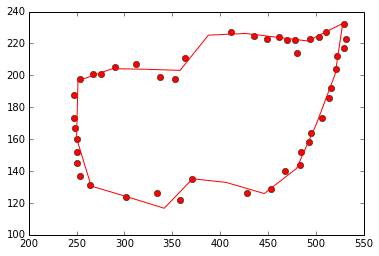

In [144]:
interpolated_obj_x_locs,interpolated_obj_y_locs = parametric_interpolate(obj_x_locs,obj_y_locs,20,True)

such operation is called a "parametric interpolation", we use a parametric B_spline to do the interpolation

In [ ]:
interpolated_obj_x_locs,interpolated_obj_y_locs

In [27]:
print majority_vote(obj_x_locs,obj_y_locs)
print precision(obj_x_locs,obj_y_locs)
print recall(obj_x_locs,obj_y_locs)

0.621613376145
0.954158717771
0.640749081612


In [145]:
polygon1 = zip(interpolated_obj_x_locs[0],interpolated_obj_y_locs[0])
polygon2 = zip(interpolated_obj_x_locs[1],interpolated_obj_y_locs[1])

In [230]:
def MunkresEuclidean(bb1,bb2):
    '''
    Given two worker's responses, 
    Compares Euclidean distances of all points in the polygon, 
    then find the best matching (min dist) config via Kuhn-Munkres
    '''
    matrix = spatial.distance.cdist(bb1,bb2,'euclidean')
    # print "Mat: " 
    # print np.ma.masked_equal(matrix,0)
    # print np.shape(np.ma.masked_equal(matrix,0))
    m = Munkres()
    try:
        indexes = m.compute(np.ma.masked_equal(matrix,0))
        total = 0
        for row, column in indexes:
            value = matrix[row][column]
            total += value
#             print '(%d, %d) -> %d' % (row, column, value)
        return total         
    except(ValueError):
        print "bad"
        return 0

In [150]:
MunkresEuclidean(polygon1,polygon2)

(0, 17) -> 11
(1, 0) -> 53
(2, 19) -> 39
(3, 1) -> 41
(4, 2) -> 19
(5, 3) -> 14
(6, 4) -> 15
(7, 5) -> 11
(8, 6) -> 8
(9, 7) -> 16
(10, 8) -> 27
(11, 9) -> 22
(12, 10) -> 11
(13, 11) -> 24
(14, 12) -> 19
(15, 13) -> 14
(16, 14) -> 9
(17, 15) -> 1
(18, 16) -> 12
(19, 18) -> 44


419.61888993442659

try using a low-rank approx for the matrix to find the "gap" and apply that to everything. The gap is fixed because we know the points are ordered. For ex, 
```
(14, 12) -> 19
(15, 13) -> 14
(16, 14) -> 9
(17, 15) -> 1
(18, 16) -> 12
(19, 18) -> 44
```

(0, 43) -> 5
(1, 44) -> 2
(2, 47) -> 34
(3, 48) -> 38
(4, 0) -> 43
(5, 49) -> 39
(6, 1) -> 42
(7, 2) -> 42
(8, 3) -> 42
(9, 4) -> 37
(10, 5) -> 22
(11, 6) -> 12
(12, 7) -> 12
(13, 8) -> 12
(14, 9) -> 10
(15, 10) -> 11
(16, 11) -> 15
(17, 12) -> 14
(18, 13) -> 9
(19, 14) -> 5
(20, 15) -> 6
(21, 16) -> 9
(22, 17) -> 11
(23, 18) -> 16
(24, 19) -> 21
(25, 20) -> 26
(26, 21) -> 27
(27, 22) -> 23
(28, 23) -> 23
(29, 24) -> 22
(30, 25) -> 9
(31, 26) -> 14
(32, 27) -> 15
(33, 28) -> 23
(34, 30) -> 7
(35, 29) -> 32
(36, 31) -> 17
(37, 32) -> 14
(38, 33) -> 13
(39, 34) -> 12
(40, 35) -> 8
(41, 36) -> 7
(42, 37) -> 9
(43, 38) -> 3
(44, 39) -> 1
(45, 40) -> 6
(46, 41) -> 12
(47, 42) -> 16
(48, 46) -> 49
(49, 45) -> 25


946.39056232163682

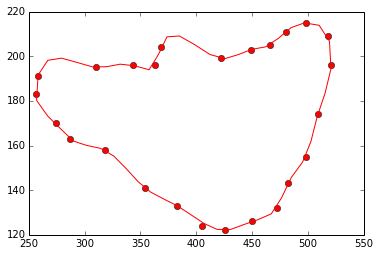

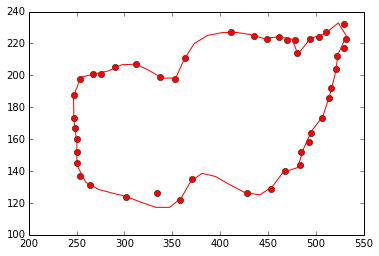

In [152]:
interpolated_obj_x_locs,interpolated_obj_y_locs = parametric_interpolate(obj_x_locs,obj_y_locs,50,True)
polygon1 = zip(interpolated_obj_x_locs[0],interpolated_obj_y_locs[0])
polygon2 = zip(interpolated_obj_x_locs[1],interpolated_obj_y_locs[1])
MunkresEuclidean(polygon1,polygon2)

In [231]:
def MunkresEuclidean(bb1,bb2):
    '''
    Given two worker's responses, 
    Compares Euclidean distances of all points in the polygon, 
    then find the best matching (min dist) config via Kuhn-Munkres
    '''
    matrix = spatial.distance.cdist(bb1,bb2,'euclidean')
    shape(matrix)
    
    # print "Mat: " 
    # print np.ma.masked_equal(matrix,0)
    # print np.shape(np.ma.masked_equal(matrix,0))
    m = Munkres()
    try:
        indexes = m.compute(np.ma.masked_equal(matrix,0))
        total = 0
        for row, column in indexes:
            value = matrix[row][column]
            total += value
#             print '(%d, %d) -> %d' % (row, column, value)
        return total         
    except(ValueError):
        print "bad"
        return 0

KeyboardInterrupt: 

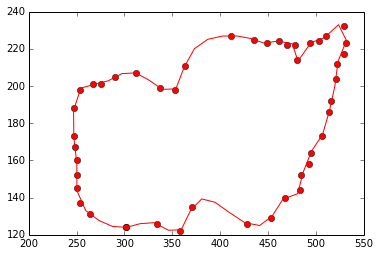

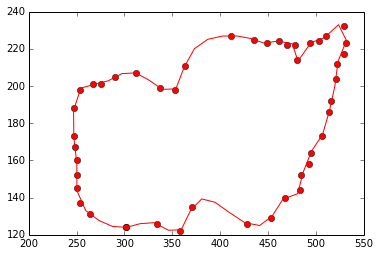

In [192]:
interpolated_obj_x_locs,interpolated_obj_y_locs = parametric_interpolate(obj_x_locs,obj_y_locs,50,True)
polygon1 = zip(interpolated_obj_x_locs[0],interpolated_obj_y_locs[0])
polygon2 = zip(interpolated_obj_x_locs[1],interpolated_obj_y_locs[1])
MunkresEuclidean(polygon1,polygon2)

In [155]:
bb1 = polygon1
bb2 = polygon2
matrix = spatial.distance.cdist(bb1,bb2,'euclidean')
m = Munkres()

indexes = m.compute(np.ma.masked_equal(matrix,0))
total = 0
for row, column in indexes:
    value = matrix[row][column]
    total += value
    print '(%d, %d) -> %d' % (row, column, value)

(0, 43) -> 5
(1, 44) -> 2
(2, 47) -> 34
(3, 48) -> 38
(4, 0) -> 43
(5, 49) -> 39
(6, 1) -> 42
(7, 2) -> 42
(8, 3) -> 42
(9, 4) -> 37
(10, 5) -> 22
(11, 6) -> 12
(12, 7) -> 12
(13, 8) -> 12
(14, 9) -> 10
(15, 10) -> 11
(16, 11) -> 15
(17, 12) -> 14
(18, 13) -> 9
(19, 14) -> 5
(20, 15) -> 6
(21, 16) -> 9
(22, 17) -> 11
(23, 18) -> 16
(24, 19) -> 21
(25, 20) -> 26
(26, 21) -> 27
(27, 22) -> 23
(28, 23) -> 23
(29, 24) -> 22
(30, 25) -> 9
(31, 26) -> 14
(32, 27) -> 15
(33, 28) -> 23
(34, 30) -> 7
(35, 29) -> 32
(36, 31) -> 17
(37, 32) -> 14
(38, 33) -> 13
(39, 34) -> 12
(40, 35) -> 8
(41, 36) -> 7
(42, 37) -> 9
(43, 38) -> 3
(44, 39) -> 1
(45, 40) -> 6
(46, 41) -> 12
(47, 42) -> 16
(48, 46) -> 49
(49, 45) -> 25


In [159]:
bb1 = polygon1
bb2 = polygon2
matrix = spatial.distance.cdist(bb1,bb2,'euclidean')[:10,:10]
m = Munkres()

indexes = m.compute(np.ma.masked_equal(matrix,0))
total = 0
for row, column in indexes:
    value = matrix[row][column]
    total += value
    print '(%d, %d) -> %d' % (row, column, value)

(0, 0) -> 81
(1, 1) -> 84
(2, 2) -> 86
(3, 3) -> 89
(4, 4) -> 87
(5, 9) -> 73
(6, 8) -> 72
(7, 5) -> 51
(8, 6) -> 43
(9, 7) -> 37


no you can not just crop it because this is a combinatorial optimization problem, it wont work 

(0, 43) -> 5
(1, 44) -> 2
(2, 47) -> 34
(3, 48) -> 38
(4, 0) -> 43
(5, 49) -> 39
(6, 1) -> 42
(7, 2) -> 42
(8, 3) -> 42
(9, 4) -> 37
(10, 5) -> 22
(11, 6) -> 12
(12, 7) -> 12
(13, 8) -> 12
(14, 9) -> 10
(15, 10) -> 11
(16, 11) -> 15
(17, 12) -> 14
(18, 13) -> 9
(19, 14) -> 5
(20, 15) -> 6
(21, 16) -> 9
(22, 17) -> 11
(23, 18) -> 16
(24, 19) -> 21
(25, 20) -> 26
(26, 21) -> 27
(27, 22) -> 23
(28, 23) -> 23
(29, 24) -> 22
(30, 25) -> 9
(31, 26) -> 14
(32, 27) -> 15
(33, 28) -> 23
(34, 30) -> 7
(35, 29) -> 32
(36, 31) -> 17
(37, 32) -> 14
(38, 33) -> 13
(39, 34) -> 12
(40, 35) -> 8
(41, 36) -> 7
(42, 37) -> 9
(43, 38) -> 3
(44, 39) -> 1
(45, 40) -> 6
(46, 41) -> 12
(47, 42) -> 16
(48, 46) -> 49
(49, 45) -> 25


946.39056232163682

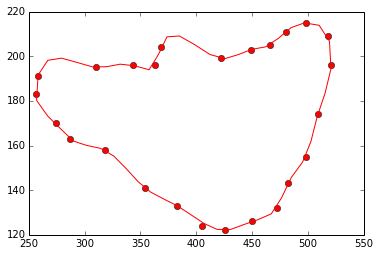

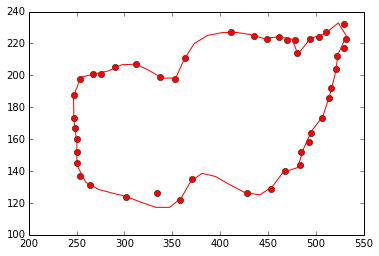

In [162]:
interpolated_obj_x_locs,interpolated_obj_y_locs = parametric_interpolate(obj_x_locs,obj_y_locs,50,True)
polygon1 = zip(interpolated_obj_x_locs[0],interpolated_obj_y_locs[0])
polygon2 = zip(interpolated_obj_x_locs[1],interpolated_obj_y_locs[1])
MunkresEuclidean(polygon1,polygon2)

compute max(dist)

In [166]:
img_info,object_tbl,bb_info,hit_info = load_info()

/Users/dorislee/.virtualenvs/py27dev/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [187]:
worker_info = pd.read_csv("../../data/worker.csv",skipfooter=1)
my_BBG  = pd.read_csv("my_ground_truth.csv")

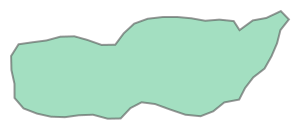

In [214]:
Polygon(polygon1)

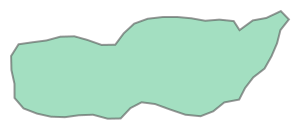

In [215]:
Polygon(polygon2)

In [220]:
obj_x_locs[0]==obj_x_locs[1]

True

In [233]:
len(bb_info)

1889

same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
same entry
(0, 21) -> 11
(1, 20) -> 14
(2, 19) -> 15
(3, 18) -> 15
(4, 17) -> 14
(5, 16) -> 13
(6, 15) -> 11
(7, 14) -> 10
(8, 13) -> 9
(9, 12) -> 9
(10, 11) -> 9
(11, 10) -> 10
(12, 9) -> 10
(13, 8) -> 12
(14, 7) -> 13
(15, 6) -> 15
(16, 5) -> 16
(17, 4) -> 16
(18, 3) -> 15
(19, 2) -> 13
(20, 1) -> 11
(21, 49) -> 9
(22, 0) -> 8
(23, 48) -> 8
(24, 47) -> 9
(25, 46) -> 9
(26, 45) -> 9
(27, 44) -> 9
(28, 43) -> 8
(29, 42) -> 7
(30, 41) -> 6
(31, 40) -> 5
(32, 39) -> 4
(33, 38) -> 3
(34, 37) -> 2
(35, 36) -> 1
(36, 35) -> 0
(37, 34) -> 0
(38, 33) -> 1
(39, 32) -> 2
(40, 31) -> 3
(41, 30) -> 4
(42, 29) -> 4
(43, 28) -> 5
(44, 27) -> 4
(45, 26) 

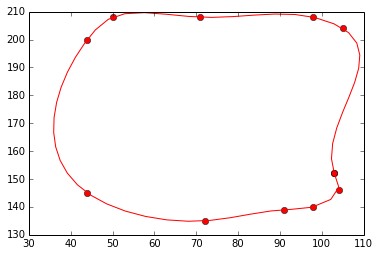

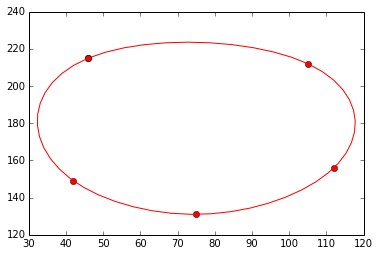

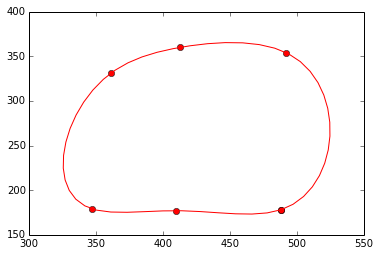

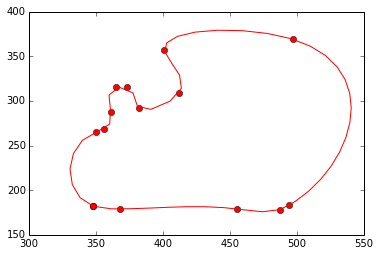

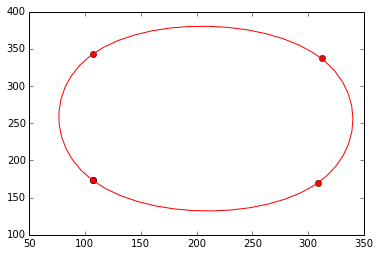

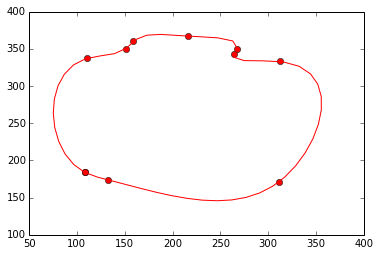

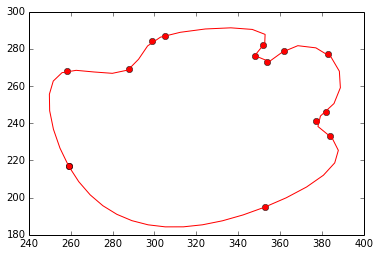

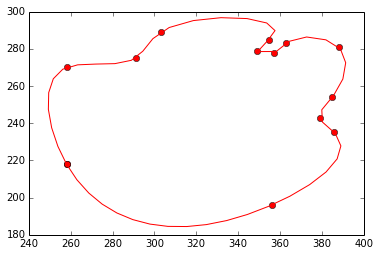

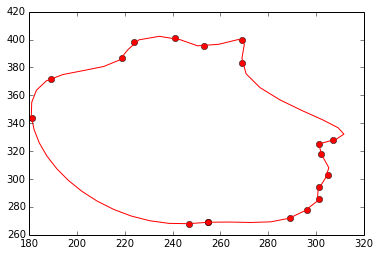

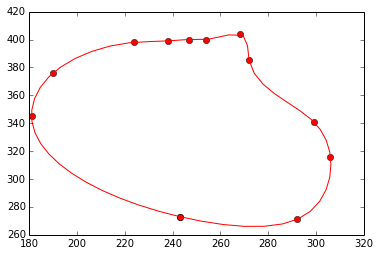

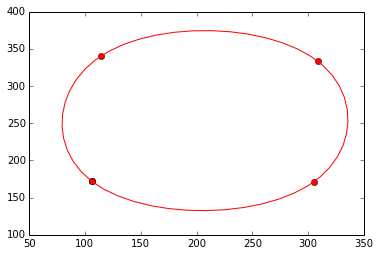

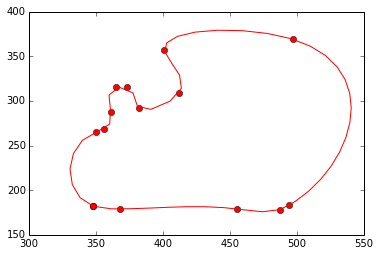

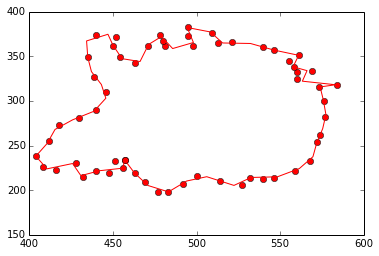

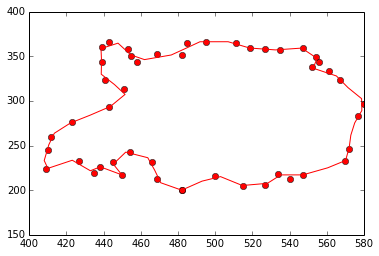

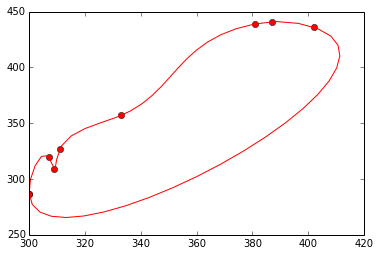

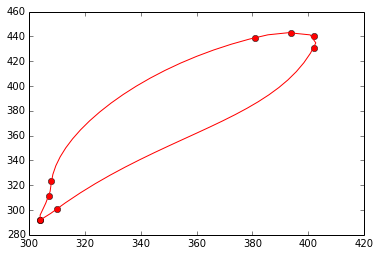

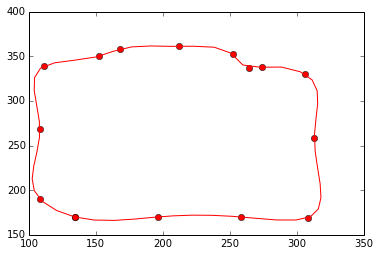

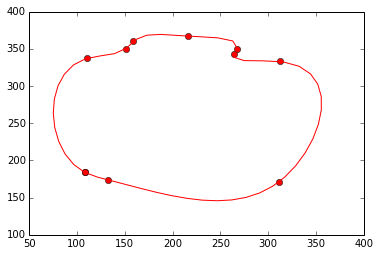

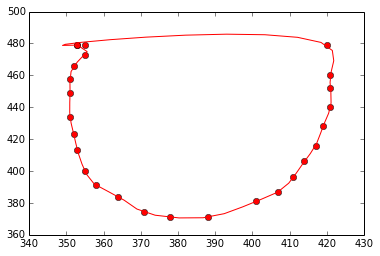

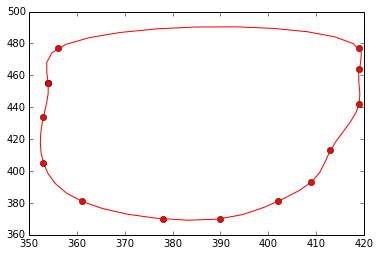

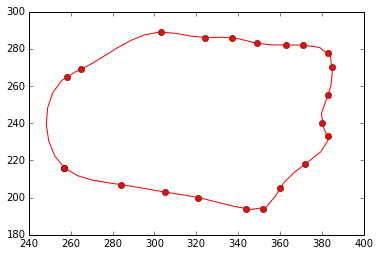

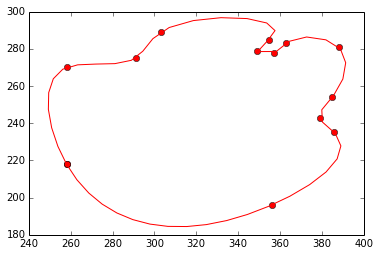

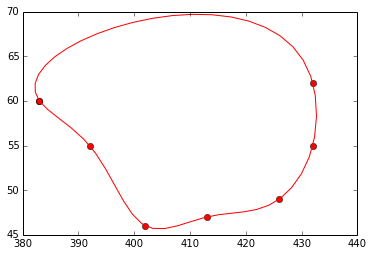

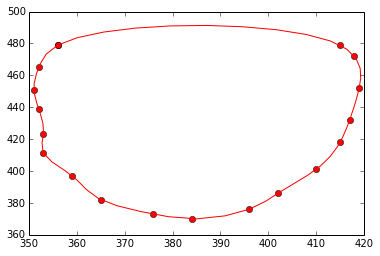

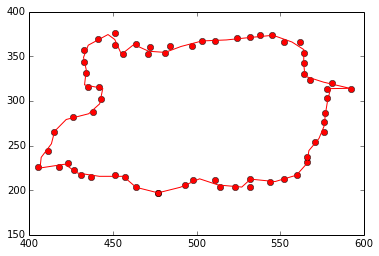

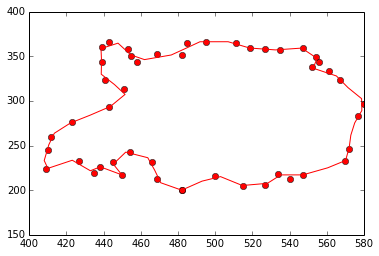

In [229]:
img_info,object_tbl,bb_info,hit_info = load_info()
i=0
for bb in bb_info.iterrows():
    #print bb
    if i<50:
        oid = bb[1]["object_id"]
        bbx_path= bb[1]["x_locs"]
        bby_path= bb[1]["y_locs"]
        my_ground_truth_match = my_BBG[my_BBG.object_id==oid]
        #print my_ground_truth_match
        worker_x_locs,worker_y_locs= process_raw_locs([bbx_path,bby_path])
        my_x_locs,my_y_locs =  process_raw_locs([my_ground_truth_match["x_locs"].iloc[0],my_ground_truth_match["y_locs"].iloc[0]])
        if my_x_locs!=worker_x_locs:
            obj_x_locs = [worker_x_locs,my_x_locs]
            obj_y_locs = [worker_y_locs,my_y_locs]
            interpolated_obj_x_locs,interpolated_obj_y_locs = parametric_interpolate(obj_x_locs,obj_y_locs,50,True)
            polygon1 = zip(interpolated_obj_x_locs[0],interpolated_obj_y_locs[0])
            polygon2 = zip(interpolated_obj_x_locs[1],interpolated_obj_y_locs[1])
            print  MunkresEuclidean(polygon1,polygon2)
            bb_info = bb_info.set_value(bb[0],"MunkresEuclidean [Self]",MunkresEuclidean(polygon1,polygon2))
        else:
            #The first few BB are bound to be the same entry as the ground truth BB
            #print "same entry"
            pass
        i+=1
    else:
        break
        

In [189]:
MunkresEuclidean(polygon1,polygon2)

KeyboardInterrupt: 

In [249]:
%%time
bb_info[~bb_info["MunkresEuclidean [Self]"].isnull()]

CPU times: user 991 µs, sys: 573 µs, total: 1.56 ms
Wall time: 1.19 ms


,object_id,worker_id,x_locs,y_locs,MunkresEuclidean [Self]
33,45,68,"[103, 105, 98, 71, 50, 44, 44, 72, 91, 98, 104]","[152, 204, 208, 208, 208, 200, 145, 135, 139, ...",418.810412
38,20,4,"[488, 492, 413, 361, 347, 410]","[178, 354, 360, 331, 179, 177]",1049.706388
39,18,6,"[107, 309, 312, 107]","[173, 170, 337, 343]",754.411039
40,9,7,"[259, 258, 288, 299, 305, 352, 348, 354, 362, ...","[217, 268, 269, 284, 287, 282, 276, 273, 279, ...",173.470154
41,13,7,"[255, 289, 296, 301, 301, 305, 302, 301, 307, ...","[269, 272, 278, 286, 294, 303, 318, 325, 328, ...",354.667423
42,20,8,"[106, 305, 309, 114]","[172, 171, 333, 340]",11353.621557
43,14,9,"[457, 463, 469, 477, 483, 492, 500, 514, 527, ...","[234, 219, 209, 198, 198, 207, 216, 210, 206, ...",730.239870
44,12,8,"[300, 402, 387, 381, 333, 311, 309, 307]","[287, 436, 441, 439, 357, 327, 309, 320]",1186.145980
45,18,9,"[134, 196, 258, 308, 313, 306, 274, 264, 252, ...","[170, 170, 170, 169, 258, 330, 338, 337, 352, ...",870.769756
46,16,10,"[353, 420, 421, 421, 421, 419, 417, 414, 411, ...","[479, 479, 460, 452, 440, 428, 416, 406, 396, ...",277.345300


In [246]:
from tqdm import tqdm

In [ ]:
%%time
img_info,object_tbl,bb_info,hit_info = load_info()
for bb in tqdm(bb_info.iterrows()):
    try:
        oid = bb[1]["object_id"]
        bbx_path= bb[1]["x_locs"]
        bby_path= bb[1]["y_locs"]
        my_ground_truth_match = my_BBG[my_BBG.object_id==oid]
        #print my_ground_truth_match
        worker_x_locs,worker_y_locs= process_raw_locs([bbx_path,bby_path])
        my_x_locs,my_y_locs =  process_raw_locs([my_ground_truth_match["x_locs"].iloc[0],my_ground_truth_match["y_locs"].iloc[0]])
        if my_x_locs!=worker_x_locs:
            obj_x_locs = [worker_x_locs,my_x_locs]
            obj_y_locs = [worker_y_locs,my_y_locs]
            interpolated_obj_x_locs,interpolated_obj_y_locs = parametric_interpolate(obj_x_locs,obj_y_locs,50,False)
            polygon1 = zip(interpolated_obj_x_locs[0],interpolated_obj_y_locs[0])
            polygon2 = zip(interpolated_obj_x_locs[1],interpolated_obj_y_locs[1])
            #print  MunkresEuclidean(polygon1,polygon2)
            bb_info = bb_info.set_value(bb[0],"MunkresEuclidean [Self]",MunkresEuclidean(polygon1,polygon2))
        else:
            #The first few BB are bound to be the same entry as the ground truth BB
            pass
    except(SystemError):
        pass

34it [00:01, 25.01it/s]

In [163]:
def DistAllWorkers(obj_x_locs,obj_y_locs,dist = MunkresEuclidean):
    '''
    Given all worker's responses,
    Perform pairwise distance comparison with all other workers
    returns quality for each worker
    '''
    interpolated_obj_x_locs,interpolated_obj_y_locs = parametric_interpolate(obj_x_locs,obj_y_locs,50,True)

    minDistList=[]
    for i in np.arange(len(obj_x_locs)-1):
        # Compare worker with another worker
#         bb1 = np.array([obj_x_locs[i],obj_y_locs[i]]).T
#         bb2  = np.array([obj_x_locs[i+1],obj_y_locs[i+1]]).T
        bb1 = zip(interpolated_obj_x_locs[i],interpolated_obj_y_locs[i])
        bb2 = zip(interpolated_obj_x_locs[i+1],interpolated_obj_y_locs[i+1])

        minDistList.append(dist(bb1,bb2))
    #worker's scores
    return np.array(minDistList)/max(minDistList)

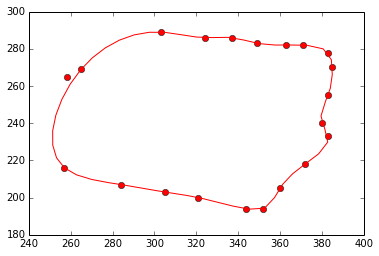

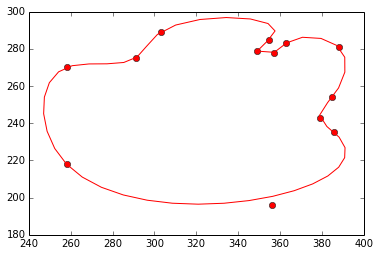

In [207]:
oid = 9
bb_info = pd.read_csv('computed_my_COCO_BBvals.csv')
bbg_info = pd.read_csv('my_ground_truth.csv')
worker =  bb_info[bb_info["object_id"]==oid].ix[47]
bbg = bbg_info[bb_info["object_id"]==oid].ix[3]
obj_x_locs = [ast.literal_eval(worker["x_locs"]),ast.literal_eval(bbg["x_locs"])]
obj_y_locs = [ast.literal_eval(worker["y_locs"]),ast.literal_eval(bbg["y_locs"])]

interpolated_obj_x_locs,interpolated_obj_y_locs = parametric_interpolate(obj_x_locs,obj_y_locs,50,True)
polygon1 = zip(interpolated_obj_x_locs[0],interpolated_obj_y_locs[0])
polygon2 = zip(interpolated_obj_x_locs[1],interpolated_obj_y_locs[1])

In [208]:
MunkresEuclidean(polygon1,polygon2)

(0, 49) -> 2
(1, 48) -> 2
(2, 10) -> 64
(3, 47) -> 4
(4, 46) -> 5
(5, 45) -> 7
(6, 21) -> 89
(7, 44) -> 5
(8, 22) -> 87
(9, 43) -> 3
(10, 42) -> 3
(11, 41) -> 8
(12, 40) -> 13
(13, 38) -> 26
(14, 39) -> 10
(15, 37) -> 22
(16, 36) -> 22
(17, 35) -> 19
(18, 34) -> 13
(19, 33) -> 6
(20, 32) -> 1
(21, 31) -> 0
(22, 30) -> 1
(23, 29) -> 3
(24, 28) -> 6
(25, 27) -> 6
(26, 26) -> 6
(27, 25) -> 7
(28, 24) -> 6
(29, 23) -> 5
(30, 20) -> 4
(31, 19) -> 15
(32, 18) -> 20
(33, 17) -> 20
(34, 16) -> 17
(35, 15) -> 12
(36, 14) -> 6
(37, 13) -> 3
(38, 12) -> 8
(39, 11) -> 12
(40, 9) -> 8
(41, 8) -> 3
(42, 7) -> 4
(43, 6) -> 8
(44, 5) -> 10
(45, 4) -> 11
(46, 3) -> 10
(47, 2) -> 7
(48, 1) -> 5
(49, 0) -> 2


659.39823160209471

In [181]:
DistAllWorkers(obj_x_locs,obj_y_locs)

(0, 43) -> 5
(1, 44) -> 2
(2, 47) -> 34
(3, 48) -> 38
(4, 0) -> 43
(5, 49) -> 39
(6, 1) -> 42
(7, 2) -> 42
(8, 3) -> 42
(9, 4) -> 37
(10, 5) -> 22
(11, 6) -> 12
(12, 7) -> 12
(13, 8) -> 12
(14, 9) -> 10
(15, 10) -> 11
(16, 11) -> 15
(17, 12) -> 14
(18, 13) -> 9
(19, 14) -> 5
(20, 15) -> 6
(21, 16) -> 9
(22, 17) -> 11
(23, 18) -> 16
(24, 19) -> 21
(25, 20) -> 26
(26, 21) -> 27
(27, 22) -> 23
(28, 23) -> 23
(29, 24) -> 22
(30, 25) -> 9
(31, 26) -> 14
(32, 27) -> 15
(33, 28) -> 23
(34, 30) -> 7
(35, 29) -> 32
(36, 31) -> 17
(37, 32) -> 14
(38, 33) -> 13
(39, 34) -> 12
(40, 35) -> 8
(41, 36) -> 7
(42, 37) -> 9
(43, 38) -> 3
(44, 39) -> 1
(45, 40) -> 6
(46, 41) -> 12
(47, 42) -> 16
(48, 46) -> 49
(49, 45) -> 25


array([ 1.])

---------------------------------------------------------------------------------------------------

In [4]:
import ast
from qualityBaseline import * 
from pycocotools.coco import COCO
import matplotlib.image as mpimg
save_db_as_csv(connect=False)
img_info,object_tbl,bb_info,hit_info = load_info()

/Users/dorislee/.virtualenvs/py27dev/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [5]:
all_x_locs = bb_info["x_locs"]
all_y_locs = bb_info["y_locs"]

In [6]:
dataDir='../../coco/'
dataType='train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=23.77s)
creating index...
index created!


In [7]:
ground_truth = pd.read_csv("../../data/object_ground_truth.csv")

In [8]:
def process_raw_locs(segmentation,COCO=False):
    '''
    Given a raw string of x and y coordinates, process it
    return a list of x_locs and y_locs
    '''
    x_locs=[]
    y_locs=[]
    if COCO:
        #COCO
#         print "Process COCO"
        poly = np.array(segmentation).reshape((len(segmentation)/2, 2))
        x_locs = list(poly[:,0])
        y_locs = list(poly[:,1])
    else: 
        bbx_path,bby_path = segmentation
        x_locs = [x for x in ast.literal_eval(bbx_path) if x is not None]
        y_locs = [y for y in ast.literal_eval(bby_path) if y is not None]


    # Append the starting point again in the end to close the BB
    x_locs.append(x_locs[0])
    y_locs.append(y_locs[0])
    return x_locs,y_locs

In [10]:
bb_info['COCO Majority Vote'] = pd.Series(np.zeros(len(bb_info)), index=bb_info.index)

#Installing shapely
``
pip install shapely==1.6b2
``

In [16]:
# Example polygon 
xy = [[130.21001, 27.200001], [129.52, 27.34], [129.45, 27.1], [130.13, 26.950001]]
polygon_shape = Polygon(xy)
# Example grid cell
gridcell_shape = box(129.5, -27.0, 129.75, 27.25)
# The intersection
polygon_shape.intersection(gridcell_shape).area

0.047150670955882656

In [34]:
obj_x_locs=[[1,3,3,1],[2,5,5,2]]
obj_y_locs=[[3,3,1,1],[2,2,0,0]]
polygon1 = Polygon(zip(obj_x_locs[0],obj_y_locs[0]))
polygon2 = Polygon(zip(obj_x_locs[1],obj_y_locs[1]))
polygon1.intersection(polygon2).area

1.0

In [109]:
from shapely.geometry import box,Polygon
def intersection(obj_x_locs,obj_y_locs,debug=False):
    # Compute intersecting area
    polygon1 = Polygon(zip(obj_x_locs[0],obj_y_locs[0])).buffer(0)
    polygon2 = Polygon(zip(obj_x_locs[1],obj_y_locs[1])).buffer(0)
    if debug : plt.imshow(polygon1.intersection(polygon2),interpolation="None")
    return polygon1.intersection(polygon2).area

In [110]:
def union(obj_x_locs,obj_y_locs,debug=False):
    # Compute union area of two given polygon 
    polygon1 = Polygon(zip(obj_x_locs[0],obj_y_locs[0])).buffer(0)
    polygon2 = Polygon(zip(obj_x_locs[1],obj_y_locs[1])).buffer(0)
    if debug : plt.imshow(polygon1.union(polygon2),interpolation="None")
    return polygon1.union(polygon2).area

In [111]:
def majority_vote(obj_x_locs,obj_y_locs): 
    '''
    Jaccard Simmilarity or Overlap Method
    used for PASCAL VOC challenge
    ''' 
    return intersection(obj_x_locs,obj_y_locs)/union(obj_x_locs,obj_y_locs)

In [112]:
def precision(obj_x_locs,obj_y_locs):
    worker_bb = Polygon(zip(obj_x_locs[0],obj_y_locs[0]))
    worker_bb_area  = worker_bb.area
#     print "Intersection: ", intersection(obj_x_locs,obj_y_locs)
#     print "Worker BB area: ",worker_bb_area
    return intersection(obj_x_locs,obj_y_locs)/float(worker_bb_area)

In [113]:
def recall(obj_x_locs,obj_y_locs):
    truth_bb = Polygon(zip(obj_x_locs[1],obj_y_locs[1]))
    truth_bb_area  = truth_bb.area
    return intersection(obj_x_locs,obj_y_locs)/float(truth_bb_area)

In [114]:
# 2 simple overlapping rectangle test example 
obj_x_locs=[[1,3,3,1],[2,5,5,2]]
obj_y_locs=[[3,3,1,1],[2,2,0,0]]
print "Check ``union``: ", union(obj_x_locs,obj_y_locs) == 9
print "Check ``intersection``: ", intersection(obj_x_locs,obj_y_locs) == 1.
print "Check ``majority_vote``: ", majority_vote(obj_x_locs,obj_y_locs) == 1./9
print "Check ``precision``: ", precision(obj_x_locs,obj_y_locs) == 1./4
print "Check ``recall``: ", recall(obj_x_locs,obj_y_locs) == 1./6

Check ``union``:  True
Check ``intersection``:  True
Check ``majority_vote``:  True
Check ``precision``:  True
Check ``recall``:  True


### Visualize all bounding boxes drawn by me , see which one is bad and redraw BBG 

In [73]:
ground_truth = pd.read_csv("../../data/object_ground_truth.csv")
worker_info = pd.read_csv("../../data/worker.csv",skipfooter=1)
my_BBG  = pd.read_csv("my_ground_truth.csv")

### Computing measures against my BBG and COCO

In [105]:
polygon1 = Polygon(zip(obj_x_locs[0],obj_y_locs[0])).buffer(0)
polygon2 = Polygon(zip(obj_x_locs[1],obj_y_locs[1])).buffer(0)

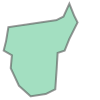

In [107]:
polygon1

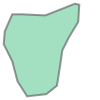

In [108]:
polygon2

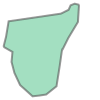

In [106]:
polygon1.intersection(polygon2)

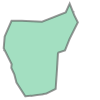

In [147]:
polygon1.union(polygon2)

In [116]:
for i in np.arange(len(img_info)):
    img_name = img_info["filename"][i]
    if 'COCO' in img_name:
        img_id = int(img_name.split('_')[-1])
        filtered_object_tbl = object_tbl[object_tbl["image_id"]==i+1]
        annIds = coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anns = coco.loadAnns(annIds)
        #for oid,bbx_path,bby_path in zip(bb_info["object_id"],bb_info["x_locs"],bb_info["y_locs"]):
        for bb in bb_info.iterrows():
            oid = bb[1]["object_id"]
            bbx_path= bb[1]["x_locs"]
            bby_path= bb[1]["y_locs"]
            if int(object_tbl[object_tbl.object_id==oid].image_id) ==i+1:
                worker_x_locs,worker_y_locs= process_raw_locs([bbx_path,bby_path])
                ground_truth_match = ground_truth[ground_truth.id==str(oid)]
                COCO_id = int(ground_truth_match["COCO_annIds"])
                
                #COCO-Annotations
                for ann in anns:
                    if COCO_id==-1:
                        #No BB for this object collected by MSCOCO
                        pass
                    elif ann['id'] == COCO_id: 
#                         print COCO_id
                        for annBB in ann["segmentation"]:
                            coco_x_locs,coco_y_locs = process_raw_locs(annBB,COCO=True)
                            obj_x_locs = [worker_x_locs,coco_x_locs]
                            obj_y_locs = [worker_y_locs,coco_y_locs]
                            bb_info = bb_info.set_value(bb[0],"COCO Majority Vote",majority_vote(obj_x_locs,obj_y_locs))
                            #bb_info = bb_info.set_value(bb[0],"Munkres Euclidean",DistAllWorkers(obj_x_locs,obj_y_locs))
                            bb_info = bb_info.set_value(bb[0],"COCO Precision",precision(obj_x_locs,obj_y_locs))
                            bb_info = bb_info.set_value(bb[0],"COCO Recall",recall(obj_x_locs,obj_y_locs))                
                my_ground_truth_match = my_BBG[my_BBG.object_id==oid]
                my_x_locs,my_y_locs =  process_raw_locs([my_ground_truth_match["x_locs"].iloc[0],my_ground_truth_match["y_locs"].iloc[0]])
                obj_x_locs = [worker_x_locs,my_x_locs]
                obj_y_locs = [worker_y_locs,my_y_locs]
                bb_info = bb_info.set_value(bb[0],"My Majority Vote",majority_vote(obj_x_locs,obj_y_locs))   
                bb_info = bb_info.set_value(bb[0],"My Precision",precision(obj_x_locs,obj_y_locs))
                bb_info = bb_info.set_value(bb[0],"My Recall",recall(obj_x_locs,obj_y_locs))
# replace all NAN values with -1, these are entries for which we don't have COCO ground truth
bb_info = bb_info.fillna(-1)

In [149]:
bb_info.to_csv("computed_my_COCO_BBvals.csv")

### Use Kolmogorov-Smirnov test to see how well the distributions fit a Gaussian 


In [124]:
from scipy import stats

(0, 1.1)

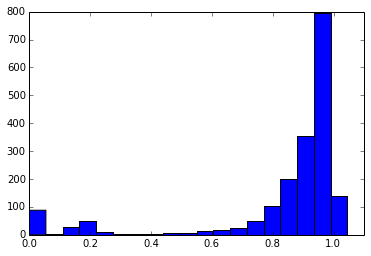

In [120]:
my_precision = np.array(bb_info["My Precision"][bb_info["My Precision"]!=-1])
my_recall = np.array(bb_info["My Recall"][bb_info["My Recall"]!=-1])
plt.figure()
plt.hist(my_precision,bins=1000)
plt.xlim(0,1.1)

In [131]:
print  stats.kstest(my_precision, 'norm')
print stats.kstest(my_recall, 'norm')

(0.63390175005377802, 0.0)
(0.66631878187717508, 0.0)


In [135]:
print stats.kstest(my_precision, 'expon')
print stats.kstest(my_recall, 'expon')

(0.38691067457919365, 0.0)
(0.41326489697122637, 0.0)


(0, 1.1)

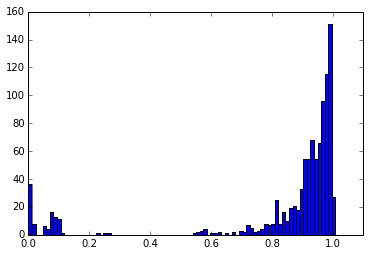

In [132]:
coco_precision = np.array(bb_info["COCO Precision"][bb_info["COCO Precision"]!=-1])
coco_recall = np.array(bb_info["COCO Recall"][bb_info["COCO Recall"]!=-1])
plt.hist(coco_precision,bins=200)
plt.xlim(0,1.1)

In [133]:
print stats.kstest(coco_precision, 'norm')
print stats.kstest(coco_recall, 'norm')

(0.64479018753305417, 0.0)
(0.67499745698052038, 0.0)


In [134]:
print stats.kstest(coco_precision, 'expon')
print stats.kstest(coco_recall, 'expon')

(0.39899709391605803, 0.0)
(0.42637866891821607, 0.0)


(0, 5)

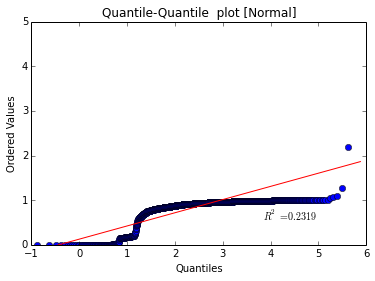

In [143]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(my_precision, dist=stats.norm, sparams=(2.5,), plot=ax)
ax.set_title("Quantile-Quantile  plot [Normal]")
ax.set_ylim(0,5)

(0, 5)

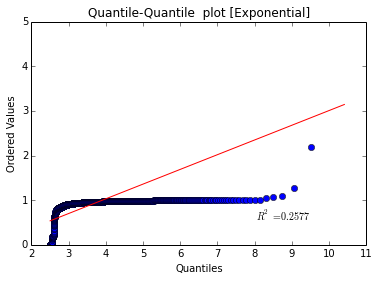

In [144]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(my_precision, dist=stats.expon, sparams=(2.5,), plot=ax)
ax.set_title("Quantile-Quantile  plot [Exponential]")
ax.set_ylim(0,5)

These distributions are very far from a normal or even an exponential distribution, even when you filter out the outliers 

Other quantities: boundary complexity, comparison with color mixture and hues from CV 